In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# !tar xf spark-2.4.5-bin-hadoop2.7.tgz

# !unzip CORD-19-research-challenge.zip 

In [125]:
sc.stop()

In [ ]:
# !pip3 install -q findspark

In [126]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-2.4.5-bin-hadoop2.7"

In [127]:

import findspark
findspark.init()

In [128]:

from pyspark.sql import SparkSession
from pyspark import SparkContext 
sc = SparkContext("local", "first app")
spark = SparkSession \
    .builder.appName("Covid-19").config("spark.driver.memory", "9g").getOrCreate() #.config("spark.driver.memory", "10g")

In [129]:
import os
import json
import pandas as pd
from pyspark import SQLContext 
from pyspark.ml.feature import  IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import *

In [130]:
from pyspark.sql.types import (
    ArrayType,
    IntegerType,
    MapType,
    StringType,
    StructField,
    StructType,
)

# Data analysis

In [51]:
metadata = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load('metadata.csv')

In [52]:
journalstat = metadata.groupby("journal").count().toPandas() 
journalstat.describe()

,count
count,17273.000000
mean,7.438893
std,57.597944
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,6082.000000


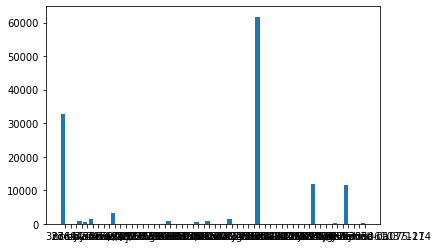

In [148]:
licensestatdf = metadata.groupby("license").count()
licensestat= licensestatdf.collect()
from matplotlib import pyplot  

indexes = list(range(len(licensestat)))
values = [r['count'] for r in licensestat]
labels = [r['license'] for r in licensestat]
bar_width = 0.35
pyplot.bar(indexes, values)
#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels)
pyplot.show()

In [146]:
licensestatdf.toPandas().head()

,license,count
0,no-cc,32800
1,32369433,1
2,27647350,1
3,cc-by-nc-nd,899
4,cc-by-nc-sa,551


In [153]:
source_xstatdf = metadata.groupby("source_x").count()

In [154]:
source_xstatdf.toPandas().head()

,source_x,count
0,Elsevier; WHO,48
1,ArXiv; Medline; PMC; WHO,3
2,Medline,49338
3,ArXiv; Medline; PMC,21
4,Elsevier; Medline; WHO,125


## Load MetaData

In [131]:
metadata = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load('metadata.csv').select("journal","abstract","title","license","source_x" , "publish_time","sha","pdf_json_files")

# Define The Json Schema

In [132]:
def generate_schema():
    author_fields = [
        StructField("first", StringType()),
        StructField("middle", ArrayType(StringType())),
        StructField("last", StringType()),
        StructField("suffix", StringType()),
    ]
    authors_schema = ArrayType(
        StructType(
            author_fields
            + [
                StructField(
                    "affiliation",
                    StructType(
                        [
                            StructField("laboratory", StringType()),
                            StructField("institution", StringType()),
                            StructField(
                                "location",
                                StructType(
                                    [
                                        StructField("settlement", StringType()),
                                        StructField("country", StringType()),
                                    ]
                                ),
                            ),
                        ]
                    ),
                ),
                StructField("email", StringType()),
            ]
        )
    )
    spans_schema = ArrayType(
        StructType(
            [
                StructField("start", IntegerType()),
                StructField("end", IntegerType()),
                StructField("text", StringType()),
                StructField("ref_id", StringType()),
            ]
        )
    )

    section_schema = ArrayType(
        StructType(
            [
                StructField("text", StringType()),
                StructField("cite_spans", spans_schema),
                StructField("ref_spans", spans_schema),
                StructField("eq_spans", spans_schema),
                StructField("section", StringType()),
            ]
        )
    )

    bib_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("ref_id", StringType()),
                StructField("title", StringType()),
                StructField("authors", ArrayType(StructType(author_fields))),
                StructField("year", IntegerType()),
                StructField("venue", StringType()),
                StructField("volume", StringType()),
                StructField("issn", StringType()),
                StructField("pages", StringType()),
                StructField(
                    "other_ids",
                    StructType([StructField("DOI", ArrayType(StringType()))]),
                ),
            ]
        ),
        True,
    )

    ref_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("text", StringType()),
                StructField("latex", StringType()),
                StructField("type", StringType()),
            ]
        ),
    )

    return StructType(
        [
            StructField("paper_id", StringType()),
            StructField(
                "metadata",
                StructType(
                    [
                        StructField("title", StringType()),
                        StructField("authors", authors_schema),
                    ]
                ),
                True,
            ),
            StructField("abstract", section_schema),
            StructField("body_text", section_schema),
            StructField("bib_entries", bib_schema),
            StructField("ref_entries", ref_schema),
            StructField("back_matter", section_schema),
        ]
    )


def extract_dataframe(spark,path):
    
    return spark.read.json(path, schema=generate_schema(), multiLine=True)
       

In [133]:
def ascii_ignore(x):
    return x.encode('ascii', 'ignore').decode('ascii')
ascii_udf = udf(ascii_ignore)

In [136]:
def LoadSelectedFeatures(path):
    
     # load trainging 
    df = extract_dataframe(spark,path)
    sqlContext = SQLContext(sc)
    selectedFeatures = df.select("paper_id","metadata.title","body_text.text")
    
    selectedFeatures.createOrReplaceTempView("parquetFile")

    view = spark.sql("SELECT paper_id,title as paper_title,text as paper_text FROM parquetFile")
    
    return view;

def LoadDataAndSaveParquet(path):
   
    selectedFeatures = LoadSelectedFeatures(path)    
    !rm -R "datajson.parquet"
    saveParq(selectedFeatures,"datajson.parquet")
 
    return selectedFeatures;

def saveParq(datfrm , path):
#     ! rm -R path
    datfrm.repartition(5).write.save(path);

def LoadParq(path):
    return spark.read.parquet(path);

In [135]:
def LoadDataFromParquet():
     
    parquetFile = LoadParq("datajson.parquet")
    
    parquetFile.createOrReplaceTempView("parquetFile")

    tmpview = spark.sql("SELECT paper_id,title as paper_title,text as paper_text FROM parquetFile")
    
    return tmpview;

In [186]:
def prepare_dataset(metadata,tmpview): 

    tmpview=tmpview.withColumn('fullText', array_join(tmpview.paper_text, "  ")).drop(tmpview.paper_text)
    
    tmpview = tmpview.withColumn("fullText", ascii_udf('fullText'))
                               
    metadata = metadata.withColumn('publish_time', metadata['publish_time'].cast(DateType()))

    dataset= metadata.join(tmpview , metadata.sha == tmpview.paper_id)

    dataset = dataset.dropDuplicates()

    dataset = dataset.fillna('NA', subset=['journal'])
   
    dataset = dataset.withColumn('publish_time',when(col('publish_time').isNull(),to_date(lit('01.01.1900'),'dd.MM.yyyy')).otherwise(col('publish_time')))
    
     dataset.withColumn('publish_year',year(dataset.publish_time))
    
#     dataset = dataset.withColumn('pub_week_of_year',weekofyear(dataset.publish_time))
    
    return dataset;


In [138]:
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

x="!()-[]{};:'"+"\,<>./?@#$%^&*_~"+'"'
      

custom_stop_words = [ 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org',
'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using',
'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
Punctuation=[char for char in x]
all_stop_words=stop_words+custom_stop_words+Punctuation

In [139]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import IDF
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

def prepareStages():
    
    tokenizer = Tokenizer().setInputCol('fullText').setOutputCol('words')
    
    sw_filter = StopWordsRemover()\
      .setStopWords(all_stop_words)\
      .setCaseSensitive(False)\
      .setInputCol("words")\
      .setOutputCol("filtered")

    cv = CountVectorizer(minTF=2., minDF=5., vocabSize=3000)\
      .setInputCol("filtered")\
      .setOutputCol("tf")
    
    idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')
    
    # create the string indexers for the categoricalColumns in our selelect feature list 

    categoricalColumns = ["journal","license","source_x"] 
    stages = [tokenizer, sw_filter,cv,idf]
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index',handleInvalid='keep')
        #stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]    

    #create the VectorAssembler for the numColumns in our selelect feature list 
    numericCols =["publish_year"] #
    assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols +["tfidf"]
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    
    return stages;

In [140]:
tmpview = LoadDataAndSaveParquet("document_parses/pdf_json/0*")
# tmpview = LoadDataFromParquet()

In [28]:
tmpview.count()

3673

In [141]:
dataset = prepare_dataset(metadata,tmpview)

In [30]:
dataset.count()

3229

In [ ]:
dataset.show(1)

In [ ]:
# from pyspark.sql.functions import udf

# def ascii_ignore(x):
#     return x.encode('ascii', 'ignore').decode('ascii')

# ascii_udf = udf(ascii_ignore)

# dataset = dataset.withColumn("paper_title", ascii_udf('paper_title')).withColumn("fullText", ascii_udf('fullText'))\
# .withColumn("abstract", ascii_udf('abstract')).withColumn("title", ascii_udf('title')).show()

In [ ]:
# training_df, validation_df, testing_df = dataset.randomSplit([0.6, 0.3, 0.1], seed=0)

In [142]:
pipeline_estimator = Pipeline(stages=prepareStages())

In [173]:
pipelineModel = pipeline_estimator.fit(dataset)
df = pipelineModel.transform(dataset)

In [174]:
df.printSchema()

root
 |-- journal: string (nullable = false)
 |-- abstract: string (nullable = true)
 |-- title: string (nullable = true)
 |-- license: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- publish_time: date (nullable = true)
 |-- sha: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- paper_id: string (nullable = true)
 |-- paper_title: string (nullable = true)
 |-- fullText: string (nullable = true)
 |-- pub_week_of_year: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- journalIndex: double (nullable = false)
 |-- journalclassVec: vector (nullable = true)
 |-- licenseIndex: double (nullable = false)
 |-- licenseclassVec: vector (nullable = true)
 |-- source_xIndex: double (nullable = false)
 |-- source_xclassVec: vector (n

In [ ]:
rf = df.select('filtered').take(1)

In [23]:
df.count()

3229

# Features reduction 

In [175]:
pca = PCA(k=100, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(df);
result=pcaModel.transform(df).select("pcaFeatures","title")
df = result.withColumnRenamed("pcaFeatures","features")
 
# result.show(truncate=False)

In [176]:
!rm -R "transformed_df.parquet"

In [177]:
saveParq(df,"transformed_df.parquet")

In [178]:
df = LoadParq("transformed_df.parquet")

# Kmeans K selections

In [29]:

import numpy as np
cost = {}

for k in range(2,400,5):
    kmeans = KMeans().setK(k).setSeed(3).setFeaturesCol('features')
    model = kmeans.fit(df)
    cost[k] = model.computeCost(df)

In [30]:
cost.keys() 

dict_keys([2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207, 212, 217, 222, 227, 232, 237, 242, 247, 252, 257, 262, 267, 272, 277, 282, 287, 292, 297, 302, 307, 312, 317, 322, 327, 332, 337, 342, 347, 352, 357, 362, 367, 372, 377, 382, 387, 392, 397])

In [31]:
# Plot the cost
df_cost = pd.DataFrame(cost.values())
df_cost.columns = ["cost"]
new_col = cost.keys() 
df_cost.insert(0, 'cluster', new_col)
df_cost.to_csv("kselectionResult.csv")
kselectionResult=  pd.read_csv("kselectionResult.csv")


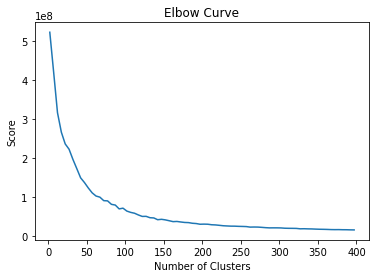

None


In [32]:
import pylab as pl
import matplotlib.pyplot as plt

plt.plot(kselectionResult.cluster, kselectionResult.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
print(plt.show())

In [ ]:
kselectionResult=  pd.read_csv("kselectionResult.csv")

# using the selected k 

In [179]:
kmeans = KMeans().setK(42).setSeed(3).setFeaturesCol('features')
model = kmeans.fit(df)

In [180]:
cluster = model.transform(df)


In [181]:
cluster.groupby("prediction").count().show(42)

+----------+-----+
|prediction|count|
+----------+-----+
|        31|   51|
|        34|    1|
|        28|  228|
|        27|    1|
|        26|    1|
|        12|    1|
|        22|    1|
|         1|    1|
|        13|    1|
|        16|  123|
|         6|    2|
|         3|    1|
|        40|    1|
|        20|    1|
|         5|    1|
|        19|   17|
|        41|    1|
|        15|    5|
|        37|    1|
|         9|    2|
|        17|    1|
|        35|    3|
|         4|    1|
|         8|    1|
|        23|    2|
|        39|    1|
|         7|  480|
|        10|   10|
|        38|    1|
|        25|    3|
|        24|    1|
|        29|    1|
|        21|    2|
|        32|    4|
|        11|   15|
|        33|    1|
|        14|    1|
|         2|    1|
|        30|    8|
|         0| 2233|
|        18|   16|
|        36|    2|
+----------+-----+



In [182]:
cluster.printSchema()

root
 |-- features: vector (nullable = true)
 |-- title: string (nullable = true)
 |-- prediction: integer (nullable = false)



In [183]:
 
from pyspark.sql.functions import broadcast
from pyspark.mllib.feature import Normalizer


from pyspark.sql.functions import udf
import random

def cosine_similarityfn(X,Y): 
    
#     return ;
     
#     return    #random.randint(0, 100);
    denom = float(X.norm(2) * Y.norm(2))
    if denom == 0.0:
        return -1.0
    else:
        return float(X.dot(Y)) / float(denom)

cosine_similarity = udf(cosine_similarityfn)

def recommendPaper(paper,N):
  
    targetdf = metadata.where(metadata.title == paper)
    
    # load the json file for this paper 
    testdf = LoadSelectedFeatures(targetdf.select('pdf_json_files').take(1)[0].pdf_json_files)
    
   
    
    testdataset= prepare_dataset(metadata,testdf)   
     
    
    pipresult = pipelineModel.transform(testdataset);
#     pipresult.printSchema(); 
   
    reducedfeature = pcaModel.transform(pipresult).select("title","pcaFeatures").withColumnRenamed("pcaFeatures","features")
    reducedfeature.printSchema()
    
    result = model.transform(reducedfeature)
     
    
    dfclass = result.select('prediction').take(1)[0].prediction
    
    

    PapersFromtheSameClass = cluster.where(cluster.prediction == dfclass)
    
    
    
    result = result.withColumnRenamed('features','features2')
    
    
    dfOfResult = result.select("features2") 
    
    
    PapersFromtheSameClass_withCosine = PapersFromtheSameClass.select('title','features').crossJoin(dfOfResult.hint("broadcast")) ;
     
#     PapersFromtheSameClass_withCosine.count()
        
    PapersFromtheSameClass_withCosine = PapersFromtheSameClass_withCosine.withColumn(
        'COSINE_SIM', cosine_similarity("features",'features2')
    ).orderBy(col('COSINE_SIM').desc());
    #
     
        
         
    
#     PapersFromtheSameClass_withCosine.printSchema()
    
     
    return PapersFromtheSameClass_withCosine.take(N)

 


In [184]:
r = recommendPaper('Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis',5)

root
 |-- title: string (nullable = true)
 |-- features: vector (nullable = true)



In [203]:
counter = 1
for i in r : 
    print(str(counter) + "\t" + str(i.COSINE_SIM)[:4]+ "\t"+i.title)
    counter = counter+1

1	0.87	cis-Preferential requirement of a − 1 frameshift product p88 for the replication of Red clover necrotic mosaic virus RNA1
2	0.86	The mechanism of RNA recombination in poliovirus
3	0.85	Molecular characterization of genome segment 2 encoding RNA dependent RNA polymerase of Antheraea mylitta cytoplasmic polyhedrosis virus
4	0.77	Loss of the Drosophila melanogaster DEAD box protein Ddx1 leads to reduced size and aberrant gametogenesis
5	0.77	Genetic diversity in the yellow head nidovirus complex
